# 1. Loading Required Libraries

In [22]:
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import scipy
import random
from surprise import AlgoBase, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from surprise import KNNWithZScore, SVD
sb.set_style('whitegrid')
pd.set_option('display.max_colwidth', None)

# 2. Loading Data

In [23]:
movies_data = pd.read_csv("../input/movielens100k/movies.csv")
movies_data.drop_duplicates(subset ="title",keep='first',inplace=True,ignore_index=True) 
ratings_data = pd.read_csv("../input/movielens100k/ratings.csv")

In [24]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9118,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9119,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9120,163949,The Beatles: Eight Days a Week - The Touring Years (2016),Documentary
9121,164977,The Gay Desperado (1936),Comedy


In [25]:
movies_data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

# 3. Preprocessing and Feature Engineering

In [26]:
NO_GENRE_LISTED = "(no genres listed)"
movies_data["genres"] = movies_data["genres"].apply(lambda genres: [ genre for genre in genres.split('|') if genre != NO_GENRE_LISTED ])

In [27]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9118,162672,Mohenjo Daro (2016),"[Adventure, Drama, Romance]"
9119,163056,Shin Godzilla (2016),"[Action, Adventure, Fantasy, Sci-Fi]"
9120,163949,The Beatles: Eight Days a Week - The Touring Years (2016),[Documentary]
9121,164977,The Gay Desperado (1936),[Comedy]


In [28]:
movies_data = movies_data.dropna()

In [29]:
movies_data

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9118,162672,Mohenjo Daro (2016),"[Adventure, Drama, Romance]"
9119,163056,Shin Godzilla (2016),"[Action, Adventure, Fantasy, Sci-Fi]"
9120,163949,The Beatles: Eight Days a Week - The Touring Years (2016),[Documentary]
9121,164977,The Gay Desperado (1936),[Comedy]


In [30]:
genres_merged = movies_data["genres"].apply(lambda genres: " ".join(genres))
genres_vectorizer = CountVectorizer(token_pattern="(?u)\\b[\\w-]+\\b")
genres_count_matrix = genres_vectorizer.fit_transform(genres_merged.tolist())

In [31]:
print("there are {} genres of movies".format(len(genres_vectorizer.vocabulary_)))

there are 19 genres of movies


<BarContainer object of 19 artists>

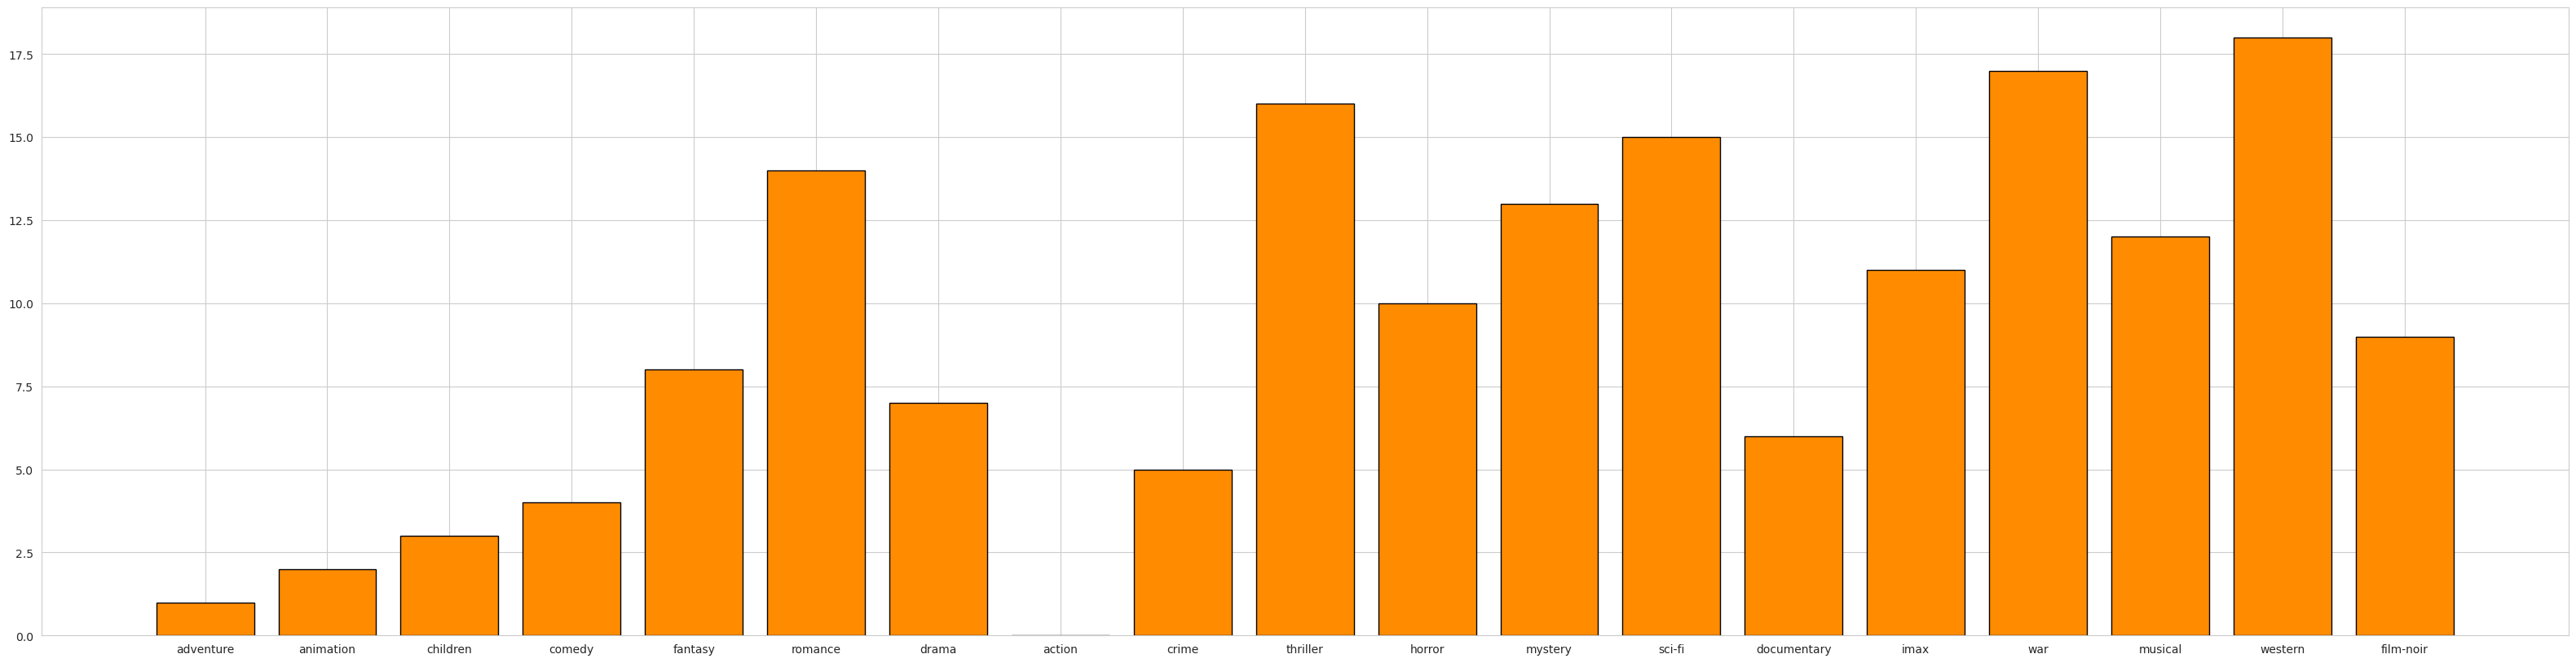

In [32]:
summed_movie_genres = genres_vectorizer.vocabulary_
plt.figure(figsize=(40,10))
plt.bar(summed_movie_genres.keys(), summed_movie_genres.values(),color = 'darkorange',edgecolor = 'black')

In [35]:
ratings_data = ratings_data[ratings_data["movieId"].isin(movies_data["movieId"])]
ratings_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [36]:
user_interactions = pd.DataFrame(columns=['userId','interactions'])

user_interactions["userId"] = ratings_data["userId"]
user_interactions["interactions"] = 0

user_interactions = user_interactions.groupby(['userId'],as_index=False).agg({ 'userId' : 'first' , 'interactions': 'count' }) 

In [37]:
user_interactions

,userId,interactions
0,1,20
1,2,76
2,3,51
3,4,204
4,5,100
...,...,...
666,667,68
667,668,20
668,669,37
669,670,31


# 3. Model Development

In [71]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 50

In [72]:
class RecallEvaluator:
    
    def __init__(self,items,trainset,testset):
        self.items = items
        self.trainset = trainset
        self.testset = testset
        
    def get_favorite_items_from_testset(self,user_id):
        
        # calculate them mean rating of the user from the test set.
        mean_rating = np.mean([rating for (_,rating) in self.trainset.ur[user_id]])
        return [item for (user,item,rating) in self.testset if rating > mean_rating and user == user_id]

    def get_interacted_items_from_testset(self,user_id):
        return [item for (user,item,_) in testset if user == user_id]
    
    def get_interacted_items_from_trainset(self,user_id):
        return [item for (item,_) in trainset.ur[user_id]]
    
    def get_not_interacted_items(self, user_id, size, seed=42):
            
        interacted_items = self.get_interacted_items_from_testset(user_id)
        non_interacted_items = list(set(self.items) - set(interacted_items))
        random.seed(seed)
        non_interacted_items = random.sample(non_interacted_items,size)
        return set(non_interacted_items)
    
    def verify_top_n_hits(self, item_id, recommendations, topn):    
            try:
                index = recommendations.index(item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit
    
    def recommend_to_evaluate(self,user_id,model):
         
            # get all the items that the user didn't interact with YET from the full item list
            non_interacted_items = list(set(self.items) - set(self.get_interacted_items_from_trainset(user_id)))
            recommendations = [model.predict(user_id,item) for item in non_interacted_items]
            recommendations.sort(key=lambda x: x.est, reverse=True)
            return recommendations
            
    
    def evaluate_model_for_user(self,user_id,model,topn):
        
        #Getting the items in test set that the user "like"
        favorite_items_testset = self.get_favorite_items_from_testset(user_id)
        
        favorite_items_count_testset = len(favorite_items_testset)
        
        if favorite_items_count_testset == 0:
            return [(0,0,0)] * len(topn)
        
        user_recommendations = [prediction.iid for prediction in self.recommend_to_evaluate(user_id,model)]        
        
        # we initialize our hits count
        hits_count = [0] * len(topn)
        
        #For each item the user likes in the test set
        for item_id in favorite_items_testset:
            
            # we generate a random sample of #EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS movies that the user didn't interact with.
            non_interacted_items = self.get_not_interacted_items(user_id,size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,seed=item_id%(2**32))
            
            # we combine them with the relevant item.
            items_to_filter_recs = non_interacted_items.union(set([item_id]))
            
            # we recommend movies to the user, these recommendations are sorted, we pick only the X+1 items.
            valid_recommendations = [recommended_item for recommended_item in user_recommendations if recommended_item in items_to_filter_recs]
                        
            #Verifying if the current interacted item is among the Top-N recommended items
            hits = [self.verify_top_n_hits(item_id,valid_recommendations,t) for t in topn]
            hits_count = np.add(hits_count, hits)
            
            
        recall = [hit_count/float(favorite_items_count_testset) for hit_count in hits_count]
        return [(rec,hit_count,favorite_items_count_testset) for rec,hit_count in zip(recall,hits_count)]
    
    
    def evaluate_model(self,model,topn,model_name):
            
        #key names of the user metrics
        keys = ['recall@{}'.format(t) for t in topn]
        users_metrics = []
        users_in_testset = set([user for (user,_,_) in self.testset])
        
        for user_id in tqdm(users_in_testset,total=len(users_in_testset)-1):
          
            user_metrics = [user_id] + self.evaluate_model_for_user(user_id,model,topn)  
            users_metrics.append(user_metrics)
            
        user_recalls = pd.DataFrame(users_metrics,columns=["user_id"] + keys)
        
        global_recall = {}
        
        for key in keys:
            
            hits_sum = np.sum([hit_count for _,(_,hit_count,_) in user_recalls[key].items()])
            interaction_counts = np.sum([interaction_count for _,(_,_,interaction_count) in user_recalls[key].items()])
            global_recall[key] = hits_sum / float(interaction_counts)
            
        global_metrics = {**{'model': model_name}, **global_recall} 
        return global_metrics, user_recalls

<h2> CF model memory based

In [85]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

traindf, testdf = sklearn_train_test_split(ratings_data[['userId', 'movieId', 'rating']],
                                   stratify=ratings_data['userId'], 
                                   test_size=0.25,
                                   random_state=42)


train = Dataset.load_from_df(traindf, reader)
test = Dataset.load_from_df(testdf, reader)

trainset = train.build_full_trainset()
_,testset = train_test_split(test,train_size=None)

movies_id = movies_data["movieId"].unique().tolist()

In [129]:
testset

[(509, 3095, 4.0),
 (311, 2875, 2.0),
 (257, 81845, 2.0),
 (73, 4816, 2.0),
 (72, 82459, 3.5),
 (602, 647, 3.0),
 (37, 595, 5.0),
 (359, 44555, 2.5),
 (297, 76251, 4.0),
 (15, 34542, 3.5),
 (242, 348, 5.0),
 (544, 5388, 4.5),
 (608, 2076, 5.0),
 (514, 1242, 4.0),
 (475, 39444, 3.5),
 (179, 81591, 5.0),
 (200, 2028, 4.5),
 (547, 6003, 3.5),
 (487, 231, 3.0),
 (13, 2761, 4.0),
 (315, 5941, 2.0),
 (496, 236, 4.0),
 (329, 1210, 4.0),
 (251, 91500, 3.5),
 (452, 4885, 2.5),
 (257, 3091, 2.5),
 (519, 6807, 3.5),
 (98, 8360, 5.0),
 (133, 7034, 2.0),
 (518, 1033, 4.0),
 (242, 2417, 3.0),
 (72, 3793, 3.0),
 (23, 2203, 4.0),
 (165, 1580, 2.5),
 (547, 2916, 3.5),
 (90, 260, 4.0),
 (161, 36, 4.0),
 (12, 1197, 1.0),
 (382, 2572, 3.0),
 (10, 3019, 4.0),
 (564, 366, 5.0),
 (312, 1199, 3.0),
 (647, 1824, 1.0),
 (564, 3635, 5.0),
 (124, 3578, 4.5),
 (15, 159972, 0.5),
 (294, 4489, 4.0),
 (548, 308, 3.0),
 (652, 1377, 5.0),
 (564, 653, 4.0),
 (547, 1227, 1.0),
 (78, 4878, 4.0),
 (423, 97866, 4.5),
 (180,

In [86]:
sim_options_ub = {'name': 'cosine','user_based': True}

In [87]:
recall_evaluator = RecallEvaluator(movies_id,trainset,testset)

In [88]:
KNNWithZscore_ub = KNNWithZScore(k=4,min_k=3,sim_options=sim_options_ub)
KNNWithZscore_ub.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [89]:
KNNWithZscore_ub_metrics , _ = recall_evaluator.evaluate_model(topn=[5,8,10],model=KNNWithZscore_ub,model_name='K-NN with z-score [user-based]')

100%|██████████| 623/623 [01:51<00:00,  9.61it/s]/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
624it [01:51,  5.58it/s]                         


In [90]:
KNNWithZscore_ub_cv = cross_validate(KNNWithZscore_ub, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9864  0.9880  0.9849  0.9865  0.0012  
MAE (testset)     0.7559  0.7596  0.7552  0.7569  0.0019  
Fit time          0.46    0.47    0.47    0.47    0.01    
Test time         1.69    1.71    1.71    1.70    0.01    


<h5> Item to item model

In [91]:
sim_options_ib = {'name': 'cosine','user_based': False}
KNNWithZscore_ib = KNNWithZScore(k=4,min_k=3,sim_options=sim_options_ib)
KNNWithZscore_ib.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [93]:
KNNWithZscore_ib_metrics , _ = recall_evaluator.evaluate_model(topn=[5,8,10],model=KNNWithZscore_ib,model_name='K-NN with z-score [item-based]')

624it [06:20,  1.64it/s]                         


In [94]:
KNNWithZscore_ib_cv = cross_validate(KNNWithZscore_ib, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0214  1.0181  1.0171  1.0188  0.0018  
MAE (testset)     0.7841  0.7835  0.7812  0.7829  0.0013  
Fit time          13.76   14.00   13.97   13.91   0.11    
Test time         9.29    8.63    8.64    8.85    0.31    


<h2> Model based approach

In [81]:
param_grid = {'n_epochs': [10,20,30], 'lr_all': [0.002, 0.005]}
grid_search = GridSearchCV(SVD, param_grid,measures=['MAE','RMSE'],cv=3,refit=True)
grid_search.fit(data)

In [82]:
svd_metrics , _ = recall_evaluator.evaluate_model(topn=[5,8,10],model=grid_search,model_name='SVD')

610it [00:59, 10.27it/s]                         


In [83]:
print(svd_metrics)

{'model': 'SVD', 'recall@5': 0.5329192546583851, 'recall@8': 0.622360248447205, 'recall@10': 0.6554865424430641}


In [95]:
global_metrics = pd.DataFrame([KNNWithZscore_ub_metrics,KNNWithZscore_ib_metrics,svd_metrics]).set_index('model')

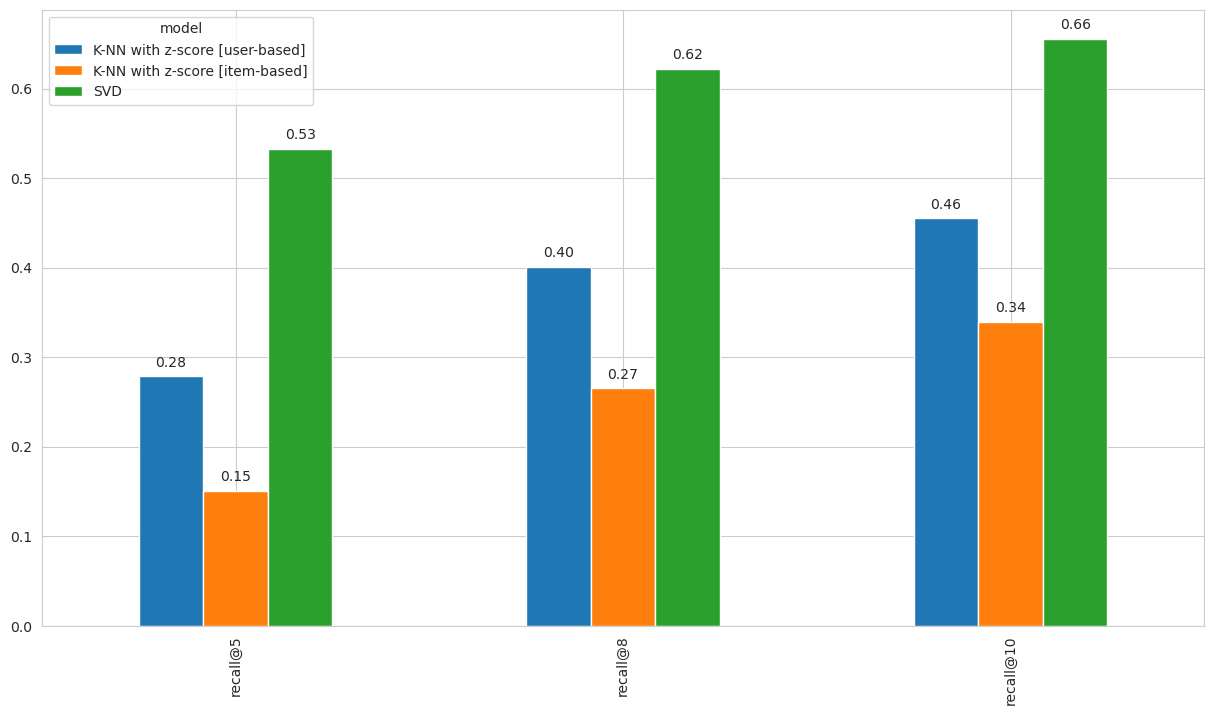

In [96]:
%matplotlib inline
ax = global_metrics.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [134]:
pred1 = grid_search.predict(601, 3095, 5.0)

In [135]:
pred2 = KNNWithZscore_ub.predict(601, 3095, 5.0)

In [140]:
pred3 = KNNWithZscore_ib.predict(601, 3095, 5.0)

In [141]:
pred1

Prediction(uid=601, iid=3095, r_ui=5.0, est=3.7645474866247466, details={'was_impossible': False})

In [142]:
pred2

Prediction(uid=601, iid=3095, r_ui=5.0, est=4.065508471642451, details={'actual_k': 4, 'was_impossible': False})

In [143]:
pred3

Prediction(uid=601, iid=3095, r_ui=5.0, est=4.223237154360591, details={'actual_k': 4, 'was_impossible': False})